# Feed-forward NN 

See: Deep Learning with TensorFlow, Md. Rezaul Karim, Giancarlo Zaccone

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [75]:
import os
dataPath = "data/digits"
if not os.path.exists(dataPath):
    os.makedirs(dataPath)
inputData = input_data.read_data_sets(dataPath, one_hot = True);

Extracting data/digits/train-images-idx3-ubyte.gz
Extracting data/digits/train-labels-idx1-ubyte.gz
Extracting data/digits/t10k-images-idx3-ubyte.gz
Extracting data/digits/t10k-labels-idx1-ubyte.gz


In [76]:
dir(inputData)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_asdict',
 '_fields',
 '_make',
 '_replace',
 '_source',
 'count',
 'index',
 'test',
 'train',
 'validation']

In [77]:
print("Shapes of arrays:\ntraining images: {}, training labels: {},\ntesting images: {}, testing labels: {}".format(
    inputData.train.images.shape, inputData.train.labels.shape, 
    inputData.test.images.shape, inputData.test.labels.shape))

Shapes of arrays:
training images: (55000, 784), training labels: (55000, 10),
testing images: (10000, 784), testing labels: (10000, 10)


## Drawing an image

In [78]:
image0 = np.resize(inputData.train.images[0], (28, 28))
label0 = inputData.train.labels[0]
label0

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

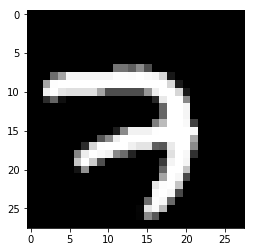

In [79]:
plt.imshow(image0, cmap = 'Greys_r');

## Network architecture (5 levels sigmoid)

Layer 1: sigmoid, L = 200 neurons

Layer 2: sigmoid, M = 100 neurons 

Layer 3: sigmoid, N =  60 neurons 

Layer 4: sigmoid, O =  30 neurons 

Layer 5: softmax,      10 neurons 

In [80]:
import math
from tensorflow.python.framework import ops
import random

In [81]:
logsPath = 'logs/sigmoid5'
batchSize = 100
learningRate = 0.003
trainingEpochs = 10
displayEpoch = 1
imageWidth = 28

numOutputs = 10

### Building the graph

In [82]:
tf.reset_default_graph()

In [83]:
X = tf.placeholder(tf.float64, shape = [None, imageWidth * imageWidth], name = 'InputData')
XX = tf.reshape(X, [-1, imageWidth * imageWidth])
Y_ = tf.placeholder(tf.float64, [None, numOutputs], name = 'LabelData') # 10 classes: digits 0-9

#### Number of neurons

In [84]:
L = 200
M = 100
N =  60
O =  30

Level 1 weights: from imageWidth * imageWidth inputs to L neurons

Level 1 bias: one for each of the L neurons

In [85]:
W1 = tf.Variable(dtype = tf.float64, initial_value = 
                 tf.truncated_normal(dtype = tf.float64, shape = [imageWidth * imageWidth, L], stddev = 0.1))
B1 = tf.Variable(dtype = tf.float64, initial_value = tf.zeros(dtype = tf.float64, shape = [L]))

Level 1 output

In [86]:
Y1 = tf.nn.sigmoid(tf.matmul(XX, W1) + B1)

Level 2

In [87]:
W2 = tf.Variable(dtype = tf.float64, 
                 initial_value = tf.truncated_normal(dtype = tf.float64, shape = [L, M], stddev = 0.1))
B2 = tf.Variable(initial_value = tf.zeros(dtype = tf.float64, shape = [M]))
Y2 = tf.nn.sigmoid(tf.matmul(Y1, W2) + B2)

Level 3

In [88]:
W3 = tf.Variable(initial_value = tf.truncated_normal(dtype = tf.float64, shape = [M, N], stddev = 0.1))
B3 = tf.Variable(initial_value = tf.zeros(dtype = tf.float64, shape = [N]))
Y3 = tf.nn.sigmoid(tf.matmul(Y2, W3) + B3)

Level 4

In [89]:
W4 = tf.Variable(initial_value = tf.truncated_normal(dtype = tf.float64, shape = [N, O], stddev = 0.1))
B4 = tf.Variable(initial_value = tf.zeros(dtype = tf.float64, shape = [O]))
Y4 = tf.nn.sigmoid(tf.matmul(Y3, W4) + B4)

Level 5 (output)

In [90]:
W5 = tf.Variable(initial_value = tf.truncated_normal(dtype = tf.float64, shape = [O, numOutputs], stddev = 0.1))
B5 = tf.Variable(tf.ones(dtype = tf.float64, shape = [numOutputs]))
Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)

Loss function: the cross-entropy between the target and the softmax activation function output (?)

In [91]:
crossEntropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = Ylogits, labels = Y_)

In [92]:
costOp = tf.reduce_mean(crossEntropy) * 100

In [93]:
correctPrediction = tf.equal(tf.argmax(Y, axis = 1), tf.argmax(Y_, axis = 1))
accuracy = tf.reduce_mean(tf.cast(correctPrediction, tf.float64))

Optimizer

In [94]:
trainOp = tf.train.AdamOptimizer(learningRate).minimize(costOp)

#### Summaries for TensorBoard

In [95]:
tf.summary.scalar("cost", costOp)
tf.summary.scalar("accuracy", accuracy)
summaryOp = tf.summary.merge_all()

### Execute Training

In [96]:
initOp = tf.global_variables_initializer()

In [97]:
from tensorflow.examples.tutorials import mnist

In [98]:
with tf.Session() as sess:
    sess.run(initOp)
    writer = tf.summary.FileWriter(logsPath, graph = tf.get_default_graph())
    
    for epoch in range(trainingEpochs):
        batchCount = int(inputData.train.num_examples / batchSize)
        for i in range(batchCount):
            batchX, batchY = inputData.train.next_batch(batchSize)
            _, summary = sess.run([trainOp, summaryOp], feed_dict = {X: batchX, Y_: batchY})
            writer.add_summary(summary, epoch * batchCount + i)
        print("Epoch: {}".format(epoch))
    print("Optimization finished.")

    print("Accuracy: {}".format(accuracy.eval(feed_dict = {X: inputData.test.images, Y_: inputData.test.labels})))

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Optimization finished.
Accuracy: 0.9679
